# EDA: Bank Credit Card Transaction Data

**Business Objective**: Analyze bank credit card transaction patterns to identify fraud indicators in PCA-anonymized features.

**Key Questions**:
1. What is the extreme class imbalance ratio? (Critical for resampling)
2. How do transaction amounts differ between fraud and legitimate transactions?
3. Are there temporal patterns in fraud?
4. Which PCA features show strongest fraud signals?


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Add src to path - works in both Jupyter and regular Python
# Method 1: Try relative path (works when running from notebooks directory)
src_path_rel = Path('../src').resolve()
if src_path_rel.exists() and str(src_path_rel) not in sys.path:
    sys.path.insert(0, str(src_path_rel))

# Method 2: Try absolute path from current working directory
src_path_abs = Path.cwd().parent / 'src' if Path.cwd().name == 'notebooks' else Path.cwd() / 'src'
if src_path_abs.exists() and str(src_path_abs) not in sys.path:
    sys.path.insert(0, str(src_path_abs))

# Import custom modules
from data_loader import load_creditcard_data, validate_data_quality

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")


Libraries imported successfully


In [5]:
# Load credit card data
# Resolve path correctly regardless of working directory
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_path = project_root / 'data' / 'raw' / 'creditcard.csv'

try:
    # Try absolute path first
    if data_path.exists():
        df = load_creditcard_data(str(data_path))
        print(f"✓ Credit card data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
        print(f"\nColumns: {list(df.columns)}")
    else:
        # Try relative path as fallback
        rel_path = Path("../data/raw/creditcard.csv").resolve()
        if rel_path.exists():
            df = load_creditcard_data(str(rel_path))
            print(f"✓ Credit card data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
            print(f"\nColumns: {list(df.columns)}")
        else:
            raise FileNotFoundError(f"Credit card data file not found at {data_path} or {rel_path}")
except FileNotFoundError as e:
    print(f"⚠ Data file not found: {e}")
    print(f"   Current working directory: {Path.cwd()}")
    print(f"   Looking for file at: {data_path}")
    print(f"   File exists: {data_path.exists()}")
    df = None
except Exception as e:
    print(f"⚠ Error loading data: {e}")
    df = None


✓ Credit card data loaded: 284,807 rows, 31 columns

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


## 1. Class Distribution Analysis (EXTREME IMBALANCE EXPECTED)


CLASS DISTRIBUTION (CRITICAL)

Non-Fraud (0): 284,315 (99.8273%)
Fraud (1):     492 (0.1727%)

⚠ EXTREME IMBALANCE RATIO: 577.9:1


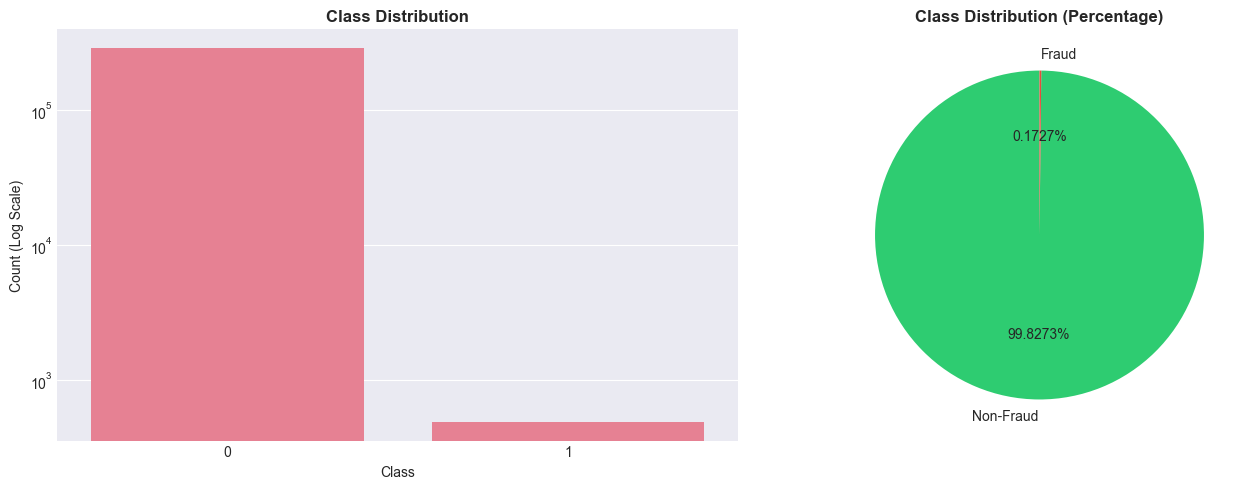


⚠ BUSINESS IMPACT:
   - Standard accuracy is misleading (would be >99% if predicting all non-fraud)
   - Must use precision, recall, F1-score, and AUC-ROC
   - SMOTE with sampling_strategy=0.1-0.3 recommended
   - Consider cost-sensitive learning


In [6]:
# Class distribution - critical for this dataset
if df is not None and 'Class' in df.columns:
    class_dist = df['Class'].value_counts()
    class_pct = df['Class'].value_counts(normalize=True) * 100
    
    print("=" * 60)
    print("CLASS DISTRIBUTION (CRITICAL)")
    print("=" * 60)
    print(f"\nNon-Fraud (0): {class_dist[0]:,} ({class_pct[0]:.4f}%)")
    print(f"Fraud (1):     {class_dist[1]:,} ({class_pct[1]:.4f}%)")
    print(f"\n⚠ EXTREME IMBALANCE RATIO: {class_dist[0]/class_dist[1]:.1f}:1")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.countplot(data=df, x='Class', ax=axes[0])
    axes[0].set_title('Class Distribution', fontweight='bold')
    axes[0].set_ylabel('Count (Log Scale)')
    axes[0].set_yscale('log')
    
    axes[1].pie([class_pct[0], class_pct[1]], labels=['Non-Fraud', 'Fraud'], 
                autopct='%1.4f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
    axes[1].set_title('Class Distribution (Percentage)', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n⚠ BUSINESS IMPACT:")
    print("   - Standard accuracy is misleading (would be >99% if predicting all non-fraud)")
    print("   - Must use precision, recall, F1-score, and AUC-ROC")
    print("   - SMOTE with sampling_strategy=0.1-0.3 recommended")
    print("   - Consider cost-sensitive learning")


## 2. Transaction Amount Analysis


TRANSACTION AMOUNT ANALYSIS

Fraud Transactions:
  Mean: $122.21
  Median: $9.25
  Std: $256.68
  Min: $0.00, Max: $2125.87

Non-Fraud Transactions:
  Mean: $88.29
  Median: $22.00
  Std: $250.11


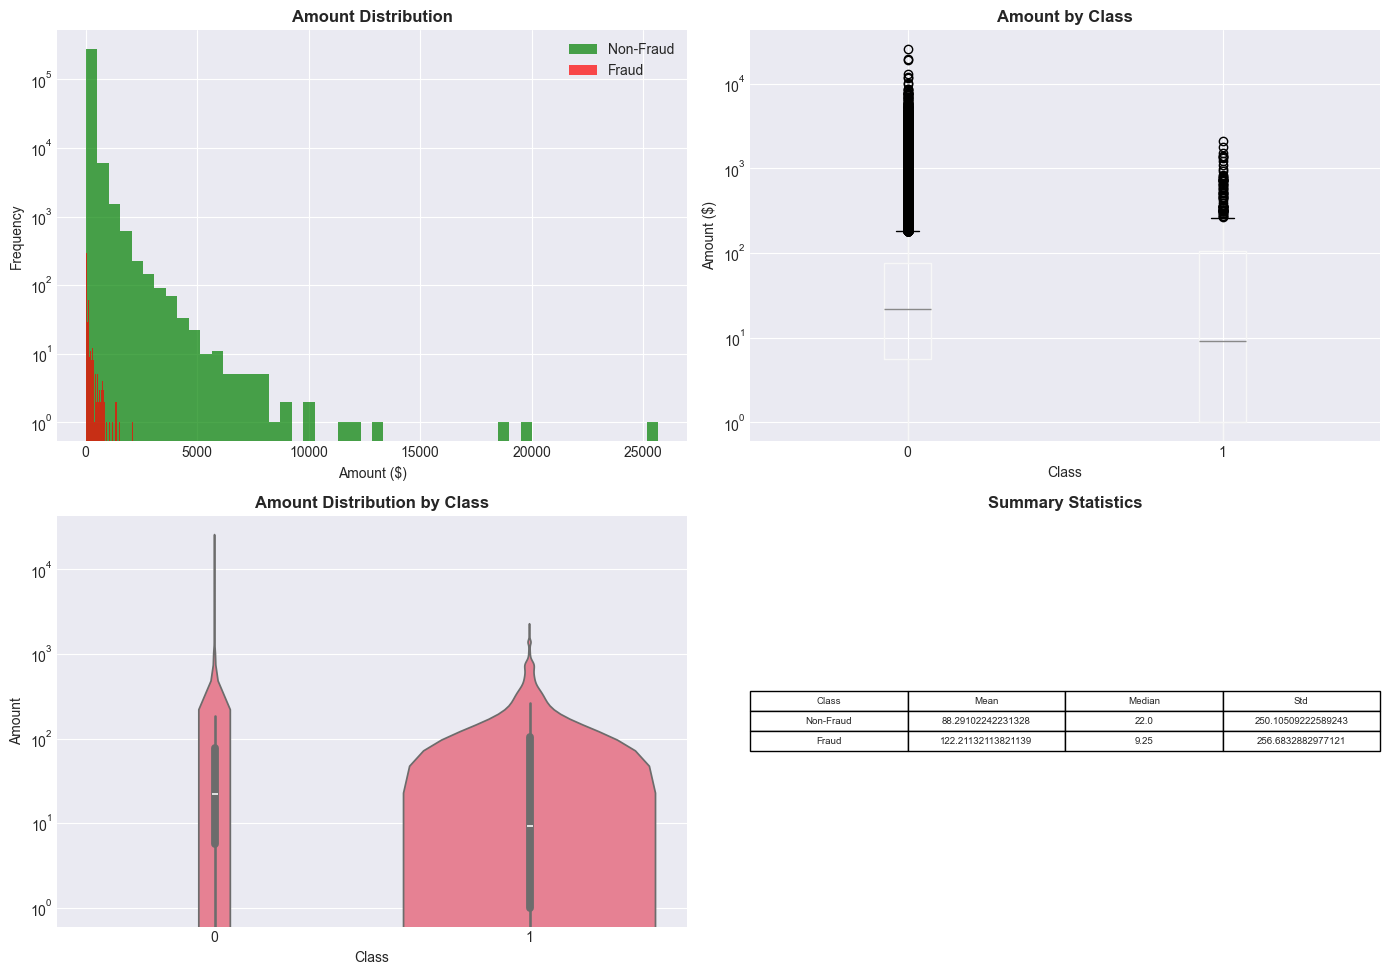

In [7]:
# Analyze transaction amounts
if df is not None and 'Amount' in df.columns:
    print("=" * 60)
    print("TRANSACTION AMOUNT ANALYSIS")
    print("=" * 60)
    
    fraud_amounts = df[df['Class'] == 1]['Amount']
    non_fraud_amounts = df[df['Class'] == 0]['Amount']
    
    print(f"\nFraud Transactions:")
    print(f"  Mean: ${fraud_amounts.mean():.2f}")
    print(f"  Median: ${fraud_amounts.median():.2f}")
    print(f"  Std: ${fraud_amounts.std():.2f}")
    print(f"  Min: ${fraud_amounts.min():.2f}, Max: ${fraud_amounts.max():.2f}")
    
    print(f"\nNon-Fraud Transactions:")
    print(f"  Mean: ${non_fraud_amounts.mean():.2f}")
    print(f"  Median: ${non_fraud_amounts.median():.2f}")
    print(f"  Std: ${non_fraud_amounts.std():.2f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Distribution comparison
    axes[0, 0].hist(non_fraud_amounts, bins=50, alpha=0.7, label='Non-Fraud', color='green')
    axes[0, 0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='red')
    axes[0, 0].set_title('Amount Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Amount ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')
    
    # Box plot
    df.boxplot(column='Amount', by='Class', ax=axes[0, 1])
    axes[0, 1].set_title('Amount by Class', fontweight='bold')
    axes[0, 1].set_ylabel('Amount ($)')
    axes[0, 1].set_yscale('log')
    
    # Violin plot
    sns.violinplot(data=df, x='Class', y='Amount', ax=axes[1, 0])
    axes[1, 0].set_title('Amount Distribution by Class', fontweight='bold')
    axes[1, 0].set_yscale('log')
    
    # Statistical summary
    summary_df = pd.DataFrame({
        'Class': ['Non-Fraud', 'Fraud'],
        'Mean': [non_fraud_amounts.mean(), fraud_amounts.mean()],
        'Median': [non_fraud_amounts.median(), fraud_amounts.median()],
        'Std': [non_fraud_amounts.std(), fraud_amounts.std()]
    })
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    axes[1, 1].table(cellText=summary_df.values, colLabels=summary_df.columns,
                     cellLoc='center', loc='center')
    axes[1, 1].set_title('Summary Statistics', fontweight='bold')
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()


## 3. Temporal Analysis (Time Feature)


TEMPORAL FRAUD PATTERNS


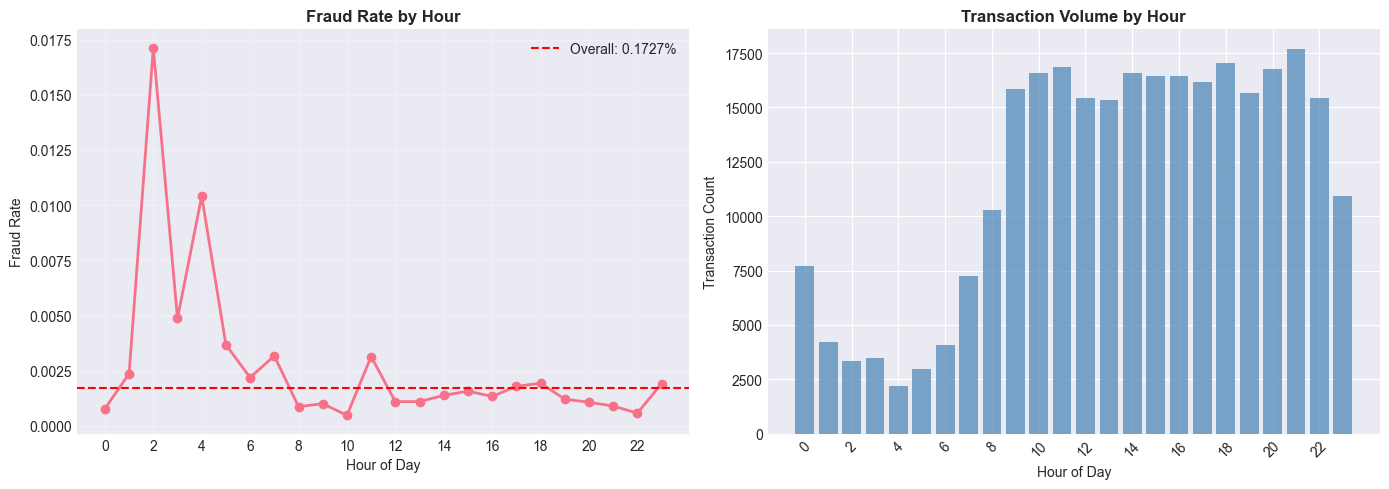

In [8]:
# Analyze temporal patterns (OPTIMIZED)
# Check if df exists and has required columns
try:
    if df is not None and 'Time' in df.columns:
        print("=" * 60)
        print("TEMPORAL FRAUD PATTERNS")
        print("=" * 60)
        
        # OPTIMIZED: Use vectorized operations and avoid creating unnecessary columns
        # Convert Time to hours using efficient numpy operations
        hours = (df['Time'].values / 3600) % 24
        hours = hours.astype(np.int32)  # Convert to integer for faster groupby
        
        # OPTIMIZED: Use value_counts and groupby with single aggregation for speed
        # Create temporary dataframe only for grouping
        temp_df = pd.DataFrame({'hour': hours, 'Class': df['Class'].values})
        
        # OPTIMIZED: Calculate aggregations separately for better performance
        fraud_by_hour = temp_df.groupby('hour', observed=True).agg({
            'Class': ['count', 'sum', 'mean']
        })
        fraud_by_hour.columns = ['total', 'fraud_count', 'fraud_rate']
        fraud_by_hour = fraud_by_hour.reset_index()
        
        # OPTIMIZED: Pre-calculate overall fraud rate
        overall_fraud_rate = df['Class'].mean()
        
        # Create visualizations
        plt.figure(figsize=(14, 5))
        ax1 = plt.subplot(1, 2, 1)
        # OPTIMIZED: Use matplotlib directly instead of seaborn for faster plotting
        ax1.plot(fraud_by_hour['hour'], fraud_by_hour['fraud_rate'], marker='o', linewidth=2, markersize=6)
        ax1.set_title('Fraud Rate by Hour', fontweight='bold')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Fraud Rate')
        ax1.axhline(y=overall_fraud_rate, color='r', linestyle='--', 
                    label=f'Overall: {overall_fraud_rate:.4%}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xticks(range(0, 24, 2))
        
        ax2 = plt.subplot(1, 2, 2)
        # OPTIMIZED: Use bar plot directly instead of seaborn barplot
        ax2.bar(fraud_by_hour['hour'], fraud_by_hour['total'], color='steelblue', alpha=0.7)
        ax2.set_title('Transaction Volume by Hour', fontweight='bold')
        ax2.set_xlabel('Hour of Day')
        ax2.set_ylabel('Transaction Count')
        ax2.set_xticks(range(0, 24, 2))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Store hour column in dataframe for potential future use
        if 'hour' not in df.columns:
            df['hour'] = hours
    else:
        print("⚠ Data not loaded or 'Time' column missing. Please run the data loading cell first.")
except NameError:
    print("⚠ Variable 'df' is not defined. Please run the data loading cell (Cell 2) first.")
except Exception as e:
    print(f"⚠ Error in temporal analysis: {e}")
    import traceback
    traceback.print_exc()


## 4. PCA Features Analysis (V1-V28)


PCA FEATURES ANALYSIS

Top 10 Features Most Correlated with Fraud:


,Correlation
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539
V3,0.192961
V7,0.187257
V11,0.154876
V4,0.133447
V18,0.111485


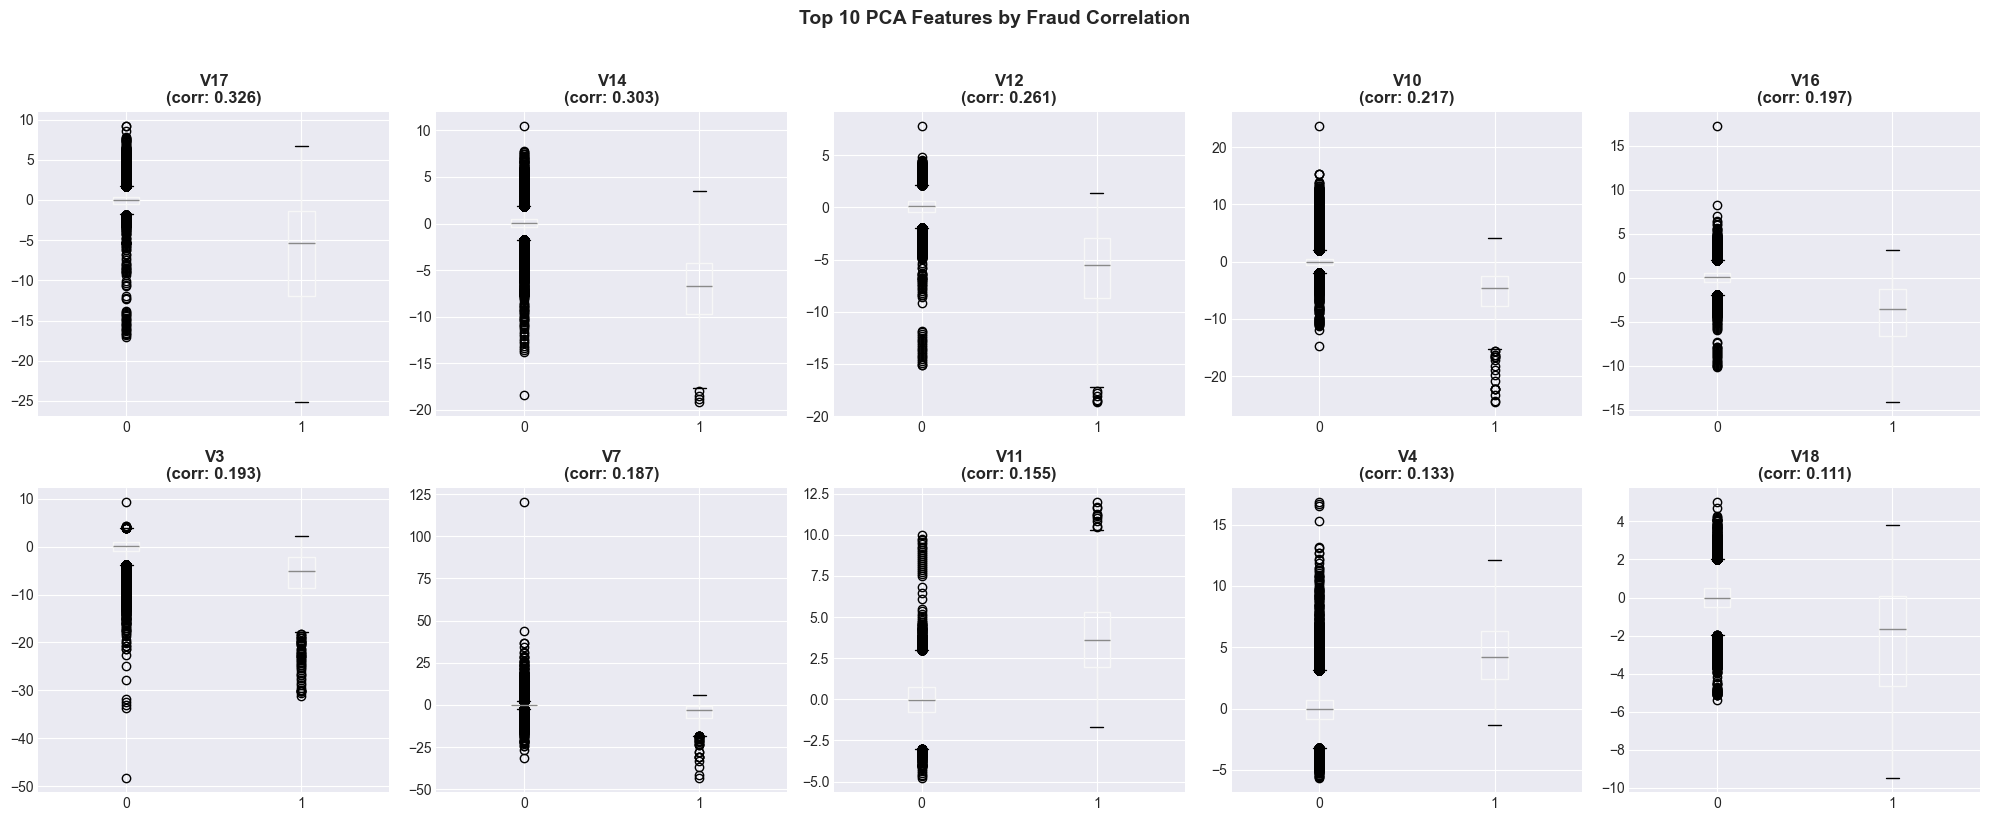

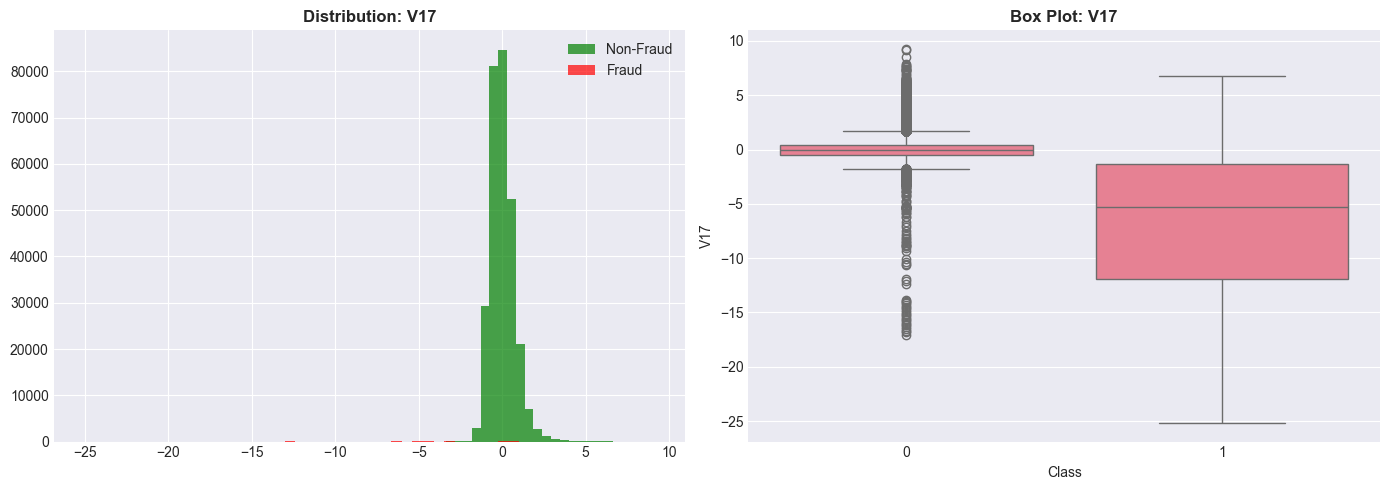

In [9]:
# Analyze PCA features
if df is not None:
    pca_features = [f'V{i}' for i in range(1, 29) if f'V{i}' in df.columns]
    
    if len(pca_features) > 0:
        print("=" * 60)
        print("PCA FEATURES ANALYSIS")
        print("=" * 60)
        
        # Correlation with fraud
        correlations = df[pca_features + ['Class']].corr()['Class'].drop('Class').abs().sort_values(ascending=False)
        
        print("\nTop 10 Features Most Correlated with Fraud:")
        display(correlations.head(10).to_frame('Correlation'))
        
        # Visualize top correlated features
        top_features = correlations.head(10).index.tolist()
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        
        for idx, feature in enumerate(top_features):
            df.boxplot(column=feature, by='Class', ax=axes[idx])
            axes[idx].set_title(f'{feature}\n(corr: {correlations[feature]:.3f})', fontweight='bold')
            axes[idx].set_xlabel('')
        
        plt.suptitle('Top 10 PCA Features by Fraud Correlation', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Distribution comparison for top feature
        top_feature = correlations.index[0]
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        df[df['Class'] == 0][top_feature].hist(bins=50, alpha=0.7, label='Non-Fraud', ax=axes[0], color='green')
        df[df['Class'] == 1][top_feature].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[0], color='red')
        axes[0].set_title(f'Distribution: {top_feature}', fontweight='bold')
        axes[0].legend()
        
        sns.boxplot(data=df, x='Class', y=top_feature, ax=axes[1])
        axes[1].set_title(f'Box Plot: {top_feature}', fontweight='bold')
        plt.tight_layout()
        plt.show()


## 5. Data Quality and Summary


In [10]:
# Data quality check
if df is not None:
    quality_report = validate_data_quality(df, "CreditCard")
    
    print("=" * 60)
    print("DATA QUALITY SUMMARY")
    print("=" * 60)
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicates: {df.duplicated().sum()}")
    
    # Save cleaned data
    output_path = Path("../data/processed/creditcard_cleaned.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"\n✓ Data saved to: {output_path}")
    
    print("\n" + "=" * 60)
    print("KEY INSIGHTS FOR MODELING")
    print("=" * 60)
    print("1. EXTREME class imbalance - requires SMOTE or advanced resampling")
    print("2. Transaction amounts differ between fraud/non-fraud")
    print("3. PCA features show varying correlation with fraud")
    print("4. Temporal patterns exist - time-based features valuable")
    print("5. Focus on precision-recall, not accuracy")
    print("=" * 60)


DATA QUALITY SUMMARY
Shape: (284807, 32)
Missing values: 0
Duplicates: 1081

✓ Data saved to: ..\data\processed\creditcard_cleaned.csv

KEY INSIGHTS FOR MODELING
1. EXTREME class imbalance - requires SMOTE or advanced resampling
2. Transaction amounts differ between fraud/non-fraud
3. PCA features show varying correlation with fraud
4. Temporal patterns exist - time-based features valuable
5. Focus on precision-recall, not accuracy
